# 앙상블 학습과 랜덤 포레스트

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 7.1 투표 기반 분류기
- 직접 투표 분류기: 다수결 투표로 정해지는 분류기
    - 각각의 예측기가 서로 독립적이고 오차에 상관관계가 없고 성능이 절반을 넘는다면 많은 예측기로 더 좋은 성능을 만들 수 있음
- 간접 투표 분류기: 확률을 이용하여 정해지는 분류기
    - 각각의 예측기가 클래스에 대한 확률을 알 수 있어야함

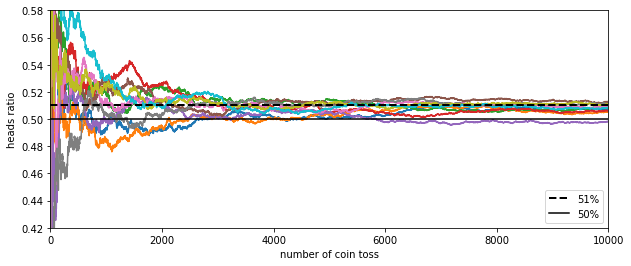

In [2]:
# 앞면이 나올 확률이 0.51인 동전을 가정
heads_proba = 0.51 # 앞면 확률 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32) # 0~1 사이 난수 중 heads_proba를 기준으로 True/False
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1) # cumsum ==> 원소들의 누적합을 계산

plt.figure(figsize=(10,4))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%") # 0.51 점선
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%") # 0.5 실선
plt.xlabel("number of coin toss")
plt.ylabel("heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show() # 동전 던진 횟수가 커질수록 heads_proba(0.51)에 근접하는 것을 알 수 있음

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
# 직접 투표 앙상블 생성(모델 중 가장 많이 투표받은 클래스로 예측)
from sklearn.ensemble import RandomForestClassifier # RandomForestClassifier ==> 분류 RF
from sklearn.ensemble import VotingClassifier # VotingClassifier ==> 투표 기반 분류기
from sklearn.linear_model import LogisticRegression # LogisticRegression => 로지스틱 회귀
from sklearn.svm import SVC # SVC ==> 분류 SVM

log_clf = LogisticRegression(solver='liblinear', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma='auto', random_state=42) # auto ==> 특성 수의 역수

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard') # 직접 투표 기반 분류기 생성 // voting ==> 투표 방법(hard ==> 직접 투표 분류기)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,...
                                        

In [5]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf): # 각각의 모델 생성 후 정확도 측정
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


In [6]:
# 간접 투표 앙상블 생성(개별 분류기의 예측을 평균을 내어 확률이 가장 높은 클래스 예측)
log_clf = LogisticRegression(solver='liblinear', random_state=42) # 로지스틱 모델은 클래스 예측 확률 존재
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42) # RF 모델은 클래스 예측 확률 존재
svm_clf = SVC(gamma='auto', probability=True, random_state=42) # 간접 투표는 클래스 예측 확률이 필요하므로 probability=True

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft') # 간접 투표 기반 분류기 생성 // voting ==> 투표 방법(soft ==> 간접 투표 분류기)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,...
                                        

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf): # 각각의 모델 생성 후 정확도 측정
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred)) # 이 데이터에서는 간접 투표 앙상블이 더 높은 성능을 보임

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


## 7.2 배깅과 페이스팅
- 배깅: 부트스트래핑을 이용하여 훈련 세트에서 중복을 허용하여 샘플링
- 페이스팅: 훈련 세트에서 중복을 허용하지 않고 샘플링
- 훈련을 마치면 수집 함수에서 분류의 경우 통계적 최빈값(직접 투표방식)으로 분류, 회귀의 경우 평균을 계산
- 개별의 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨신 편향적이나 수집 함수를 통과하면 편향과 분산이 일반적으로 더 감소
- 예측기는 모두 동시에 다른 CPU 코어나 서버에서 병렬로 학습이 가능

#### 7.2.1 사이킷런의 배깅과 페이스팅
- 부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높으나 이는 예측기들의 상관관계를 줄이므로 앙상블 분석의 분산을 감소시킴
- 전반적으로 배깅이 더 나은 모델을 만들어 선호되나 시간과 여유가 된다면 교차 검증으로 배깅 페이스팅 모두 평가해볼 것

In [8]:
# 결정 트리 분류기 500개를 이용한 배깅 앙상블(무작위 100개의 샘플에 대해)
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42) # bootstrap ==> True는 배깅, False는 페이스팅
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred)) # 배깅 앙상블의 정확도

0.904


In [9]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree)) # 단일 결정 트리의 정확도(배깅 앙상블보다 낮음)

0.856


In [10]:
# 단일 결정 트리와 500개의 결정 트리(배깅 앙상블) 비교 그래프
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100) # -1.5~2.5 구간을 100개로 나눔
    x2s = np.linspace(axes[2], axes[3], 100) # -1~1.5 구간을 100개로 나눔
    x1, x2 = np.meshgrid(x1s, x2s) # meshgrid ==> 두 배열의 가능한 조합을 모두 생성
    X_new = np.c_[x1.ravel(), x2.ravel()] # 조합 생성
    y_pred = clf.predict(X_new).reshape(x1.shape) # 예측
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour: # contour가 Trud이면(기본값 True)
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

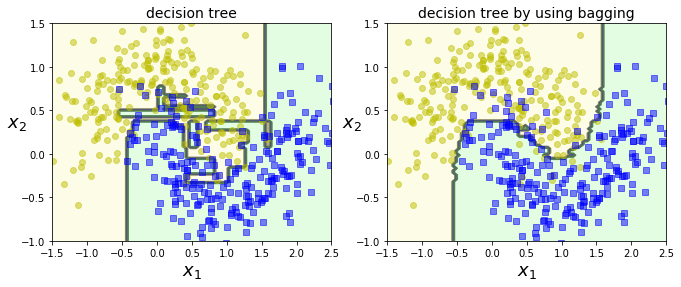

In [11]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("decision tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("decision tree by using bagging", fontsize=14)
plt.show() # 오른쪽 모델(배깅 앙상블)이 더욱 일반화가 잘 됨

### 7.2.2 oob 평가
- 배깅을 사용하면 어떤 샘플은 여러 번 선택되는 반면 어떤 샘플은 선택되지 않을 수 있음
- 각 예측기의 훈련 샘플은 평균적으로 63% 정도만 샘플링되는데 선택되지 않은 37%의 훈련 샘플을 oob 샘플이라고 부름
- 예측기가 훈련되는 동안에 oob 샘플을 사용하지 않으므로 교차 검증이나 검증 세트를 사용하지 않고 oob 샘플을 사용해 평가가 가능
- 사이킷런에서 배깅을 만들 때 oob_score=True로 지정하면 훈련이 끝난 후 자동으로 oob 평가를 수행하며 결과는 obb_score_에 저장되어 있음

In [12]:
# oob score 확인
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

In [13]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred) # oob score와 정확도는 매우 유사

0.912

In [14]:
bag_clf.oob_decision_function_ # oob_decision_function_ ==> oob score의 클래스 확률 반환

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08379888, 0.91620112],
       [0.31693989, 0.68306011],
       [0.02923977, 0.97076023],
       [0.97687861, 0.02312139],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.71195652, 0.28804348],
       [0.83957219, 0.16042781],
       [0.97777778, 0.02222222],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97297297, 0.02702703],
       [0.95238095, 0.04761905],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.38947368, 0.61052632],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.96685083, 0.03314917],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.64804469, 0.35195531],
       [0.

## 7.3 랜덤 패치와 랜덤 서브스페이스
- 배깅은 max_featrues, bootstrap_features 두 매개변수로 조절할 수 있는 특성 샘플링도 지원(max_samples, bootstrap과 동일하나 샘플이 아닌 특성에 대한 샘플링), 이는 (이미지와 같은) 매우 고차원 데이터셋을 다룰 때 유리
- 랜덤 패치 방식: 훈련 특성과 샘플을 모두 샘플링하는 것
- 랜덤 서브스페이스 방식: 훈련 샘플을 모두 사용하고(bootstrap=False, max_samples=1.0) 특성을 샘플링하는 것(bootstrap=True, max_samples=1미만)

## 7.4 랜덤 포레스트
- 랜덤 포레스트는 일반적으로 배깅 방법(또는 페이스팅)을 적용한 결정 트리의 앙상블
- 랜덤 포레스트는 결정 트리와 배깅의 대부분의 매개변수를 갖고 있음(단, splitter=True, presort=False, max_features=1.0는 고정)
- 랜덤 포레스트는 노드를 분할할 때 최선의 특성을 찾는 대신 최적의 특성을 찾는 무작위성을 선호되는데 이는 트리를 다양하게 만들고 편향을 손해보는 대신 부산을 낮추어 더 훌륭한 모델을 만듬

In [15]:
# 배깅모델 예측(디시전 트리를 사용하여 랜덤 포레스트(바로 밑)와 거의 유사하게 만든 것)
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [16]:
# 랜덤 포레스트 예측
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [17]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # 거의 동일한 예측

0.976

In [18]:
# 아이리스 데이터 변수 중요도(랜덤 포레스트에서)
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


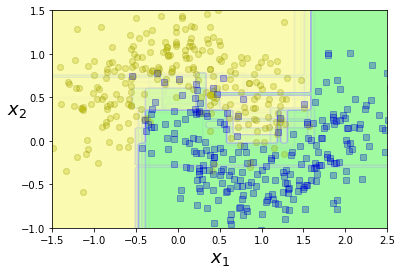

In [19]:
# 15개의 랜덤 포레스트 결정 경계 확인
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train)) # 정수를 0~데이터 크기만큼 데이터 크기 개수만큼 생성
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False) # 사용자 정의 함수 사용

plt.show() # 랜덤 포레스트는 같은 데이터여도 매우 다양한 모델을 만듬

#### 7.4.1 엑스트라 트리 (익스트림 랜덤 트리)
- 랜덤 포레스트에서 극단적으로 무작위성을 강조한 모델(편향을 높이고 분산은 감소)
- 보통의 트리처럼 최적의 임계값을 찾는 대신 무작위성을 위해 후보 특성을 사용해 무작위로 분할한 다음에 그 중에서 최상의 분할을 선택
- 모든 노드에서 최적의 임계값을 찾는 것이 주 계산량이므로 일반적으로 엑스트라 트리는 랜덤 포레스트보다 훨씬 빠름
- 사이킷런에서 ExtraTreesClassifier // ExtraTreeRegressor로 사용

#### 7.4.2 특성 중요도
- 랜덤 포레스트는 어떤 특성이 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 확인(특성 중요도 측정하기 쉬움)
- 사이킷런은 훈련이 끝난 뒤 특성마다 자동으로 중요도를 계산하며 전체 합은 1이 되도록 정규화
- 특성 중요도는 feature_importances_ 변수에 저장되어 있음

In [20]:
# from sklearn.datasets import fetch_mldata // mnist = fetch_mldata('MNIST original')
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1) # NIST 데이터

In [21]:
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [22]:
# 데이터 이미지로 표현하는 함수
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot, interpolation="nearest")
    plt.axis("off")

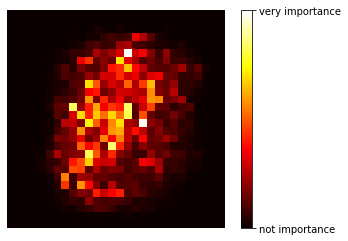

In [23]:
import matplotlib

plot_digit(rnd_clf.feature_importances_) # 변수 중요도 이미지화하기

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()]) # 바 표현하기(범위 지정)
cbar.ax.set_yticklabels(['not importance', 'very importance'])
plt.show()

## 7.5 부스팅
- 부스팅은 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법을 말하며 앞의 모델을 보완해나가며 일련의 예측기를 학습시키는 것

#### 7.5.1 아다부스트
- 이전 예측기를 보완하는 방법은 이전 모델이 과소평가 했던 훈련 샘플의 가중치를 더 높여가며 학습하기 어려운 샘플에 점점 더 맞춰가는 것

In [24]:
# 아다부스트 분류 모델 적용(DecisionTreeClassifier(max_depth=1)가 분류에서 아다부스트의 기본 설정(회귀의 경우 깊이=3))
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

##### 추가 설명
- 아다부스트에서 예측기란 사용되는 기초적인 모델을 말함
- 사이킷런은 SAMME라는 아다부스트의 다중 클래스 버전을 사용하는데 클래스가 2개라면 SAMME와 아다부트스가 동일
- 예측기가 클래스 확률을 추정할 수 있다면 SAMME.R(예측값 대신 클래스 확률 기반)라는 SAMME의 변종을 사용하며 일반적으로 성능이 더 좋음

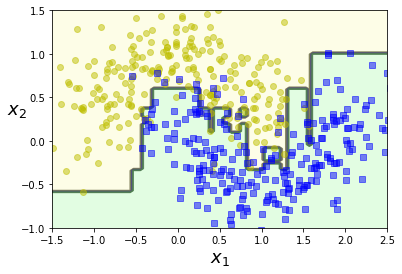

In [25]:
plot_decision_boundary(ada_clf, X, y) # plot_decision_boundary 사용자 정의 함수 사용

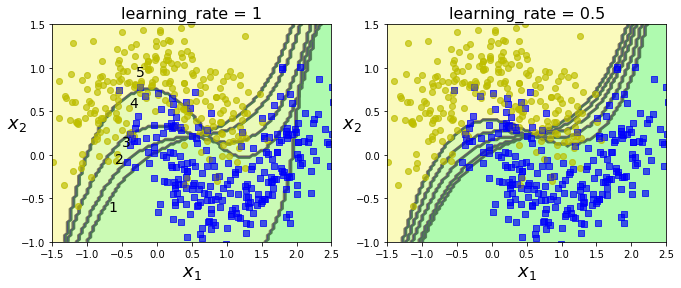

In [26]:
# SVM을 아다부스트처럼 이용한 그래프
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)): # 학습률 1과 0.5
    sample_weights = np.ones(m) # 초기 모든 샘플의 가중치 1로
    plt.subplot(subplot)
    if subplot == 121: # 첫번째 그림일 경우 번호 붙여넣기
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)        
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma='auto', random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights) # 모두 동일한 가중치 부여
        y_pred = svm_clf.predict(X_train) # 예측
        sample_weights[y_pred != y_train] *= (1 + learning_rate) # 오분류된 값에 추가 가중치 부여
        plot_decision_boundary(svm_clf, X, y, alpha=0.2) # plot_decision_boundary 사용자 정의 함수
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)

plt.show()

In [27]:
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_")) # 모델 매개변수 확인(다른 모델도 가능)

['base_estimator_',
 'classes_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_']

#### 7.5.2 그래디언트 부스팅 (그래디언트 트리 부스팅)
- 아다부트스와 동일하게 이전 모델의 가중치를 보정하나 아다부스트처럼 반복마다 수정하는 대신 예측기가 만든 잔여 오차에 수정함
- subsample 매개변수로 트리가 훈련할 샘플의 크기를 지정 가능하며 이런 기법을 확률적 그래디언트 부스팅이라 함(편향은 높아지나 분산은 낮아짐)

In [28]:
# 그래디언트 부스팅 회귀 모델 구현
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

from sklearn.tree import DecisionTreeRegressor # DecisionTreeRegressor ==> 결정 트리 회귀 모델

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y) # 첫 번째 모델 생성

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [29]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2) # 첫 번째 모델에서 생긴 잔여 오차로 두 번째 모델 생성

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [30]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3) # 두 번째 모델에서 생긴 잔여 오차로 세 번째 모델 생성

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [31]:
X_new = np.array([[0.8]])

In [32]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3)) # X_new에 대한 3개의 모델의 예측의 합

In [33]:
y_pred # X_new의 예측 합 값

array([0.75026781])

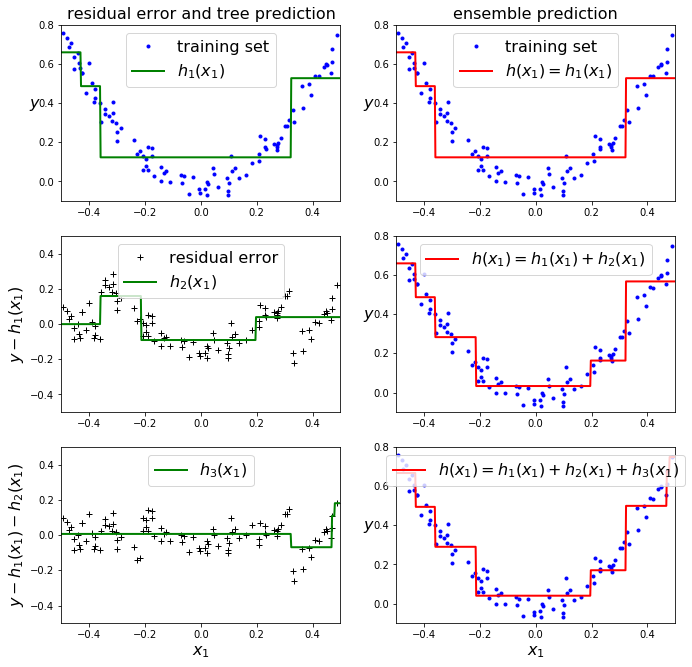

In [34]:
# 그래디언트 부스팅 회귀 모델 구현 그래프
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500) # axes[0]~axes[1] 구간 500개로 나눔
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors) # 모델들의 예측의 합
    plt.plot(X[:, 0], y, data_style, label=data_label) # 청색 점으로 표시
    plt.plot(x1, y_pred, style, linewidth=2, label=label) # 예측값 붉은 선으로 표시
    if label or data_label: # label 또는 data_label의 기입값이 있으면 범례 표시
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("residual error and tree prediction", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("ensemble prediction", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="residual error")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.show() # 왼쪽 열 => 개별 결정 트리의 예측, 오른쪽 열 => 앙상블 예측(아래로 갈수록 누적 예측)
# 트리가 앙상블에 추가될수록 앙상블 예측이 점점 더 좋아짐

In [35]:
# 그래디언트 부스팅 모델 적용(축소(규제 방법) ==> learning_rate를 작게 설정(단, 많은 트리가 필요하며 일반적으로 성능이 좋아짐))
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=0.1, random_state=42) # 트리 3개 모델
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [36]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42) # 트리 200개 모델
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

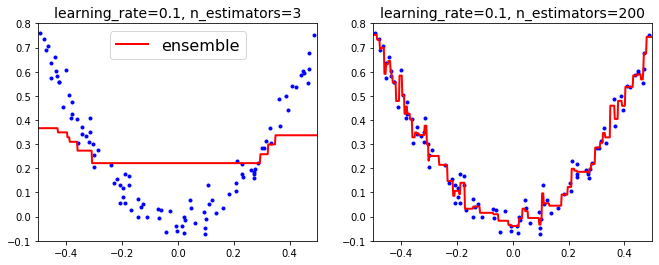

In [37]:
# 축소 규제시 트리 개수에 따른 그래프
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="ensemble") # plot_predictions 사용자 정의 함수
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8]) # plot_predictions 사용자 정의 함수
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.show() # 트리가 적은 왼쪽 모델의 경우 과소적합, 트리가 많은 오른쪽 모델의 경우 과대적합

In [38]:
# 조기 종료를 사용한 그래디언트 부스팅
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)] # y_pred가 모델의 예측값이 되도록 설정
# staged_predict ==> 훈련의 각 단계에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자를 반환
bst_n_estimators = np.argmin(errors) # 최소의 error값 저장

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=55,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [39]:
min_error = np.min(errors)

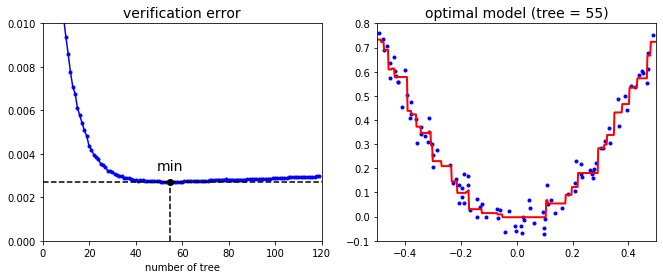

In [40]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-") # error 청색으로 표시
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--") # (55,0) ~ (55,min) 까지 직선 점선으로 표시
plt.plot([0, 120], [min_error, min_error], "k--") # (0,min) ~ (120,min) 점선으로 표시
plt.plot(bst_n_estimators, min_error, "ko") # 최적의 지점 검정점으로 표시
plt.text(bst_n_estimators, min_error*1.2, "min", ha="center", fontsize=14) # 텍스트 min 표시
plt.axis([0, 120, 0, 0.01])
plt.xlabel("number of tree")
plt.title("verification error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8]) # plot_predictions 사용자 정의 함수 사용
plt.title("optimal model (tree = %d)" % bst_n_estimators, fontsize=14)
plt.show() # 검증 오차 -> 왼쪽, 최적 모델 -> 오른쪽

In [41]:
# 조기 종료 (warm_start=True ==> fit 매서트가 호출될 때 기존 트리 유지하고 훈련을 추가할 있도록 해줌)
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42) # warm_start=True

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120): # 1~120의 트리 순환
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5: # 성능 개선이 5번까지 안되면 종료
            break  # 조기 종료

In [42]:
print(gbrt.n_estimators) # 확인 결과 61번째에서 멈춤(즉, 55번째가 최적을 의미)

61


In [43]:
print("최소 검증 MSE:", min_val_error)

최소 검증 MSE: 0.002712853325235463


### 7.5.3 XG부스트
- 그래디언트 부스팅의 느리고 과대적합의 위험이 있는 단점을 보완한 모델
- CART를 기반으로 하며 과대적합을 방지하기 위한 규제, 조기종료의 기능을 포함하고 있음(결국 그래디언트 부스팅을 기본으로 함)

In [44]:
try:
    import xgboost
except ImportError as ex:
    print("에러: xgboost 라이브러리가 설치되지 않았습니다.")
    xgboost = None

In [45]:
if xgboost is not None:  # 책에는 없음
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print("검증 MSE:", val_error)

[18:44:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
검증 MSE: 0.0028512559726563943


In [46]:
if xgboost is not None:  # 책에는 없음
    xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print("검증 MSE:", val_error)

[18:44:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.286719
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.258221
[2]	validation_0-rmse:0.232634
[3]	validation_0-rmse:0.210526
[4]	validation_0-rmse:0.190232
[5]	validation_0-rmse:0.172196
[6]	validation_0-rmse:0.156394
[7]	validation_0-rmse:0.142241
[8]	validation_0-rmse:0.129789
[9]	validation_0-rmse:0.118752
[10]	validation_0-rmse:0.108388
[11]	validation_0-rmse:0.100155
[12]	validation_0-rmse:0.09208
[13]	validation_0-rmse:0.084791
[14]	validation_0-rmse:0.078699
[15]	validation_0-rmse:0.073248
[16]	validation_0-rmse:0.069391
[17]	validation_0-rmse:0.066277
[18]	validation_0-rmse:0.063458
[19]	validation_0-rmse:0.060326
[20]	validation_0-rmse:0.0578
[21]	validation_0-rmse:0.055643
[22]	validation_0-rmse:0.053943
[23]	validation_0-rmse:0.053138
[24]	validation_0

In [47]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

[18:44:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:40] WARNI

[18:44:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:41] WARNI

[18:44:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:42] WARNI

[18:44:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:42] WARNI

[18:44:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:43] WARNI

[18:44:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:43] WARNI

[18:44:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:44] WARNI

[18:44:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:44] WARNI

[18:44:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:45] WARNI

[18:44:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:45] WARNI

[18:44:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:46] WARNI

[18:44:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:46] WARNI

[18:44:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:47] WARNI

[18:44:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:47] WARNI

[18:44:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:48] WARNI

In [48]:
%timeit GradientBoostingRegressor().fit(X_train, y_train) # XG부스트가 9.82로 훨씬 더 빠름

55.3 ms ± 1.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


##### XG부스트 하이퍼파라미터 (일부만)
1. n_estimators(혹은 num_boost_round): 결정 트리 개수
2. max_depth: 최대 깊이
3. colsample_bytree: 컬럼의 샘플링 비율(max_features와 비슷)
4. learning_rate: 학습률
5. min_split_loss: 리프 노드를 추가적으로 나눌지 결정하는 값
6. subsample: weak learner가 학습에 사용하는 데이터 샘플링 비율
7. reg_lambda: L2 규제
8. reg_alpha: L1 규제
9. early_stopping_rounds: 최대 몇 번동안 성능 개선이 없으면 조기종료 할 것인지
10. eval_set: 조기 종료할 때 어떤 데이터를 보고 평가할 것인지

## 7.6 스태킹
- "앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수 대신 취합하는 모델을 훈련시킬 수 없을까?"라는 아이디어에서 출발
- 각각의 예측기가 예측을 하고 마지막 예측기(블렌더 또는 메타 학습기)가 이 예측들을 받아들여 최종 예측을 하는 구조(사이킷런에서 지원 안함)
- 각각의 모델이 예측한 데이터를 다시 훈련 세트로 사용해서 학습하는 것(과적합 문제로 기본적인 스태킹은 사용하지 않고 CV기반 스태킹을 사용함)

## 7.7 연습문제

#### 1. 정확히 같은 훈련 데이터로 다섯 개의 다른 모델을 훈련시켜서 모두 95%의 정확도를 얻었다면 이 모델들을 연결하여 더 좋은 결과를 얻을 수 있을까요? 가능하다면 어떻게 해야 할까요? 그렇지 않다면 왜일까요?
- 5개의 모델을 훈련시켜 모두 95%의 정확도를 달성했다면 이들을 연결하여 투표 앙상블을 만들어 더 나은 결과를 기대할 수 있습니다. 만약 모델이 서로 다르다면 훨씬 좋습니다. 만약 다른 훈련 샘플에서 훈련되었다면 더더욱 좋습니다(이것이 배깅과 페이스팅 앙상블의 핵심입니다). 하지만 그렇지 않더라도 모델이 서로 많이 다르다면 여전히 좋은 결과를 냅니다.

#### 2. 직접 투표와 간접 투표 분류기 사이의 차이점은 무엇일까요?
- 직접 투표 분류기는 앙상블에 있는 각 분류기의 선택을 카운트해서 가장 많은 투표를 얻은 클래스를 선택합니다. 간접 투표 분류기는 각 클래스의 평균적인 확률 추정값을 계산해서 가장 높은 확률을 가진 클래스를 고릅니다. 이 방식은 신뢰가 높은 투표에 더 가중치를 주고 종종 더 나은 성능을 만들어 냅니다. 하지만 앙상블에 있는 모든 분류기가 클래스 확률을 추정할 수 있어야 사용할 수 있습니다.

#### 3. 배깅 앙상블의 훈련을 여러 대의 서버에 분산시켜 속도를 높일 수 있을까요? 페이스팅 앙상블, 부스팅 앙상블, 랜덤 포레스트, 스태킹 앙상블의 경우는 어떨까요?
- 배깅 앙상블의 각 예측기는 독립적이므로 여러 대의 서버에 분산하여 앙상블의 훈련 속도를 높일 수 있습니다. 페이스팅 앙상블과 랜덤 포레스트도 같은 이유로 동일합니다. 그러나 부스팅 앙상블의 예측기는 이전 예측기를 기반으로 만들어지므로 훈련이 순차적이어야하고 여러 대의 서버에 분산해서 얻을 수 있는 이득이 없습니다. 스태킹 앙상블의 경우 한 층의 모든 예측기가 각각 독립적이므로 여러 대의 서버에서 병렬로 훈련될 수 있습니다. 그러나 한 층의 있는 예측기들은 이전 층의 예측기들이 훈련된 후에 훈련할 수 있습니다.

#### 4. oob 평가의 장점은 무엇인가요?
- oob 평가를 사용하면 배깅 앙상블의 각 예측기가 훈련에 포함되지 않은(즉, 따로 떼어놓은) 샘플을 사용해 평가됩니다. 이는 추가적인 검증 세트가 없어도 편향되지 않게 앙상블을 평가하도록 도와줍니다. 그러므로 훈련에 더 많은 샘플을 사용할 수 있어서 앙상블의 성능은 조금 더 향상될 것입니다.

#### 5. 무엇이 엑스트라 트리를 일반 랜덤 포레스트보다 더 무작위하게 만드나요? 추가적인 무작위성이 어떻게 도움이 될까요? 엑스트라 트리는 일반 랜덤 포레스트에 비해 느릴까요? 빠를까요?
- 랜덤 포레스트에서 트리가 성장할 때 각 노드에서 특성의 일부를 무작위로 선택해 분할에 사용합니다. 엑스트라 트리도 이는 마찮가지지만 한 단계 더 나아가서 일반 결정 트리처럼 가능한 최선의 임계점을 찾는 것이 아니라 각 특성에 대해 랜덤한 임계점을 사용합니다. 이 추가적인 무작위성은 규제처럼 작용합니다. 즉, 랜덤 포레스트가 훈련 데이터에 과대적합되었다면 엑스트라 트리는 그렇지 않을 것입니다. 또한 엑스트라 트리는 가능한 최적의 임계점을 찾지 않기 때문에 랜덤 포레스트보다 훨씬 빠르게 훈련됩니다. 그러나 예측을 할 때는 랜덤 포레스트보다 더 빠르지도 느리지도 않습니다.

#### 6. 아다부스트 앙상블이 훈련 데이터에 과소적합되었다면 어떤 매개변수를 어떻게 바꾸어야할까요?
- 아다부스트 앙상블이 훈련 데이터에 과소적합되었다면 예측기 수를 증가시키거나 기반 예측기의 규제 하이퍼파라미터를 감소시켜 볼 수 있습니다. 또한 학습률을 약간 증가시켜 볼 수 있습니다.

#### 7. 그래디언트 부스팅 앙상블이 훈련 데이터에 과대적합되었다면 학습률을 높여야 할까요? 낮춰야 할까요?
- 그래디언트 부스팅 앙상블이 훈련 세트에 과대적합되었다면 학습률을 감소시켜야 합니다. (예측기의 수가 너무 많으면) 알맞은 개수를 찾기 위해 조기 종료 기법을 사용할 수 있습니다.

#### 8. MNIST 데이터를 불러들여 훈련 세트, 검증 세트, 테스트 세트로 나눕니다. 그런 다음 랜덤 포레스트 분류기, 엑스트라 트리 분류기, SVM 같은 여러 종류의 분류기에 훈련시킵니다. 그리고 검증 세트에서 개개의 분류기보다 더 높은 성능을 내도록 이들을 간접 또는 직접 투표 분류기를 사용하는 앙상블로 연결해보세요. 앙상블을 얻고 나면 테스트 세트로 확인해보세요. 개개의 분류기와 비교해서 성능이 얼마나 향상되었나요?

#### 9. 이전 연습문제의 각 분류기를 실행해서 검증 세트에서 예측을 만들고 그 결과로 새로운 훈련 세트를 만들어보세요. 각 훈련 샘플은 하나의 이미지에 대한 전체 분류기의 예측을 담은 벡터고 타깃은 이미지의 클래스입니다. 새로운 훈련 세트에 분류기 하나를 훈련시켜보세요. 방금 블렌더를 훈련시켰습니다. 그리고 이 분류기를 모아서 스태킹 앙상블을 구성했습니다. 이제 테스트 세트에 앙상블을 평가해보세요. 테스트 세트에 각 이미지에 대해 모든 분류기로 예측을 만들고 앙상블의 예측 결과를 만들기 위해 블렌더에 그 예측을 주입합니다. 앞서 만든 투표 분류기와 비교하면 어떤가요?